In [22]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import resample # Oversampling için gerekli


DATA_PATH = "datasets/CSV_Multi_Label_Classification"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# GPU Bellek Ayarı
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU tespit edildi.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU bulunamadı.")

1 GPU tespit edildi.


In [24]:
def load_data(subset_name):
    """
    Faz 1 CSV formatını okur ve 'no_accident' sütununu oluşturur.
    """
    csv_path = os.path.join(DATA_PATH, subset_name, "_classes.csv")
    df = pd.read_csv(csv_path)

    df.columns = df.columns.str.strip()    # Sütun isimlerindeki boşlukları temizle

    df['filename'] = df['filename'].apply(lambda x: os.path.join(DATA_PATH, subset_name, x.strip()))    # Tam dosya yolunu oluştur

    df['no_accident'] = ((df['moderate'] == 0) & (df['severe'] == 0)).astype(int)#no_accidient sınıfını oluştujr.

    return df

# Verileri Yükle
train_df = load_data("train")
valid_df = load_data("valid")
test_df = load_data("test")

print(f"\nOrijinal Train Sayısı: {len(train_df)}")
print("-" * 30)
print(train_df[['moderate', 'severe', 'no_accident']].sum())

Sütunlar: Index(['filename', 'moderate', 'severe', 'no_accident'], dtype='object')

Orijinal Train Sayısı: 10469
------------------------------
moderate       3402
severe         6853
no_accident     259
dtype: int64


In [25]:
def balance_data(df):
    """
    Azınlık sınıfı (no_accident) çoğunluk sınıfına (severe) eşitlenene kadar çoğaltır.
    """
    # 1. Sınıfları Ayır
    df_severe = df[df['severe'] == 1]
    df_moderate = df[df['moderate'] == 1]
    df_no_acc = df[df['no_accident'] == 1]

    # Hedef sayı (En kalabalık sınıf kadar olsun)
    target_count = len(df_severe)

    print(f"Hedeflenen sınıf sayısı: {target_count}")

    # 2. Oversampling (Azınlık sınıfları çoğalt)

    # No Accident Artırma
    df_no_acc_upsampled = resample(df_no_acc,
                                   replace=True,     # Örnekleri tekrarla
                                   n_samples=target_count, # Hedef sayıya ulaş
                                   random_state=42)

    # Moderate Artırma (Eğer moderate de azsa onu da artırabiliriz)
    # Raporda sadece no_accident vurgusu vardı ama dengeli olması için bunu da artırmak iyidir.
    df_moderate_upsampled = resample(df_moderate,
                                     replace=True,
                                     n_samples=target_count,
                                     random_state=42)

    # 3. Birleştir
    df_balanced = pd.concat([df_severe, df_moderate_upsampled, df_no_acc_upsampled])

    # Karıştır (Shuffle)
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

# SADECE EĞİTİM SETİNİ DENGELİYORUZ (Valid ve Test bozulmaz!)
train_df_balanced = balance_data(train_df)

print("\n--- Dengeleme Sonrası Dağılım ---")
print(train_df_balanced[['moderate', 'severe', 'no_accident']].sum())

Hedeflenen sınıf sayısı: 6853

--- Dengeleme Sonrası Dağılım ---
moderate       6898
severe         6937
no_accident    6853
dtype: int64


In [26]:
def preprocess_custom_cnn(image_path, label):
    # 1. Oku ve Decode et
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # 2. Resize
    img = tf.image.resize(img, IMG_SIZE)

    # 3. Normalizasyon (0-1 arası) -> Custom CNN için standart
    img = img / 255.0

    return img, label

def create_pipeline(df, is_train=False):
    file_paths = df['filename'].values
    # Etiket sırası önemli: [Moderate, No, Severe] veya senin belirlediğin sıra.
    # Burada dataframe sütunlarına göre veriyoruz.
    labels = df[['moderate', 'no_accident', 'severe']].values.astype('float32')

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(preprocess_custom_cnn, num_parallel_calls=tf.data.AUTOTUNE)

    if is_train:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Pipeline oluştur (Dengelenmiş train ile)
train_ds = create_pipeline(train_df_balanced, is_train=True)
valid_ds = create_pipeline(valid_df, is_train=False) # Valid orijinal kalmalı

✅ Pipeline hazır.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Blok 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok 5 (Derinlik artışı)
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Sınıflandırma
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 Sınıf: Moderate, No, Severe
])



model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_33 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_34 (Bat  (None, 109, 109, 64)     256       
 chNormalization)                                                
                                                      

In [28]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("✅ Model, düşük Learning Rate ile tekrar derlendi.")

# Eğitimi tekrar başlat
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30, # Loss düzelirse epoch sayısını artırabiliriz
    verbose=1
)

Epoch 1/25
643/643 [==============================] - 96s 143ms/step - loss: 6.9569 - accuracy: 0.6276 - val_loss: 24.4714 - val_accuracy: 0.3934
Epoch 2/25
643/643 [==============================] - 90s 140ms/step - loss: 91.6955 - accuracy: 0.5086 - val_loss: 115.9253 - val_accuracy: 0.3058
Epoch 3/25
643/643 [==============================] - 91s 141ms/step - loss: 323.2653 - accuracy: 0.5363 - val_loss: 626.5059 - val_accuracy: 0.6454
Epoch 4/25
643/643 [==============================] - 91s 140ms/step - loss: 829.5010 - accuracy: 0.6138 - val_loss: 608.3517 - val_accuracy: 0.3506
Epoch 5/25
643/643 [==============================] - 90s 140ms/step - loss: 1375.4158 - accuracy: 0.7097 - val_loss: 539.5834 - val_accuracy: 0.7669
Epoch 6/25
643/643 [==============================] - 90s 140ms/step - loss: 2378.2261 - accuracy: 0.7391 - val_loss: 2211.6526 - val_accuracy: 0.6723
Epoch 7/25
643/643 [==============================] - 90s 140ms/step - loss: 2957.7087 - accuracy: 0.7904 -

KeyboardInterrupt: 

# Oversampling öncesi dataset dağılım bilgileri

In [5]:
# Orijinal verileri yükle
original_train_df = utils.load_data('train', base_path=ORIGINAL_DATA_PATH)
original_valid_df = utils.load_data('valid', base_path=ORIGINAL_DATA_PATH)
original_test_df = utils.load_data('test', base_path=ORIGINAL_DATA_PATH)

# Tensorflow Dataset'leri oluştur
original_train_dataset = utils.create_dataset(original_train_df)
original_valid_dataset = utils.create_dataset(original_valid_df)
original_test_dataset = utils.create_dataset(original_test_df)

print("\nOrijinal Veri Seti Dağılımı:")
print(f"Train set: {len(original_train_df)} images")
print(f"Validation set: {len(original_valid_df)} images")
print(f"Test set: {len(original_test_df)} images")

print("\nOrijinal Eğitim Seti Etiket Dağılımı:")
print("Moderate Accident:", original_train_df['moderate'].sum())
print("Severe Accident:", original_train_df['severe'].sum())
print("No Accident:", original_train_df['no_accident'].sum())
print("Multi-label (Moderate & Severe):", ((original_train_df['moderate'] == 1) & (original_train_df['severe'] == 1)).sum())


Orijinal Veri Seti Dağılımı:
Train set: 10469 images
Validation set: 1004 images
Test set: 649 images

Orijinal Eğitim Seti Etiket Dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 259
Multi-label (Moderate & Severe): 45


# Oversampling sonrası dataset dağılım bilgileri

In [6]:
if not os.path.exists(os.path.join(AUGMENTED_DATA_PATH, 'train', '_classes.csv')):
    # Veri artırımı uygula ve yeni klasöre kaydet
    print("\nVeriler artırılıyor ve yeni dizine kaydediliyor...")
    utils.augment_and_save_data(original_train_df, 'train',
                                no_accident_aug_size=25, moderate_aug_size=1, severe_aug_size=0,
                                output_base_path=AUGMENTED_DATA_PATH)
else:
    print("Artırılmış veri seti zaten mevcut, mevcut veriler kullanılıyor.")


# Artırılmış veri setini yükle
train_df = utils.load_data('train', base_path=AUGMENTED_DATA_PATH)
valid_df = utils.load_data('valid', base_path=AUGMENTED_DATA_PATH)
test_df = utils.load_data('test', base_path=AUGMENTED_DATA_PATH)

# Tensorflow Dataset'leri oluştur
augmented_train_dataset = utils.create_dataset(train_df)
augmented_valid_dataset = utils.create_dataset(valid_df)
augmented_test_dataset = utils.create_dataset(test_df)

print(f"\nGüncel Train set: {len(train_df)} images")
print(f"Güncel Validation set: {len(valid_df)} images")
print(f"Güncel Test set: {len(test_df)} images")

# Güncel etiket dağılımını kontrol et
print("\nGüncel Eğitim seti etiket dağılımı:")
print("Moderate Accident:", train_df['moderate'].sum())
print("Severe Accident:", train_df['severe'].sum())
print("No Accident:", train_df['no_accident'].sum())
print("Multi-label (Moderate & Severe):", ((train_df['moderate'] == 1) & (train_df['severe'] == 1)).sum())

Artırılmış veri seti zaten mevcut, mevcut veriler kullanılıyor.

Güncel Train set: 16944 images
Güncel Validation set: 1602 images
Güncel Test set: 649 images

Güncel Eğitim seti etiket dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 6734
Multi-label (Moderate & Severe): 45


In [14]:
# Model Mimarisi Oluşturma
def create_model():
    """
    Trafik kazası sınıflandırması için Evrişimli Sinir Ağı (CNN) modelini oluşturur.
    Dropout ve L2 regülarizasyon ile overfitting azaltılmıştır.
    """
    model =models.Sequential([
        # İlk Convolutional blok
        layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),#En önemli özellikler kalacak şekilde görüntüyü yarıya indirir.
        layers.Dropout(0.2),

        # İkinci Convolutional blok
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        # Üçüncü Convolutional blok
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.4),

        # Dördüncü Convolutional Blok
        layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.4),

        #Sınıflandırma Katmanı
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"),
    ])

    # Model derleme
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Model oluştur
model = create_model()

In [15]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=8,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True# En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.5,# Öğrenme oranını %x azalt
        patience=3,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6 # En düşük learningrate oranı
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_CNN_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_13 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                      

# Orjinal veri seti ile model eğitimi ve metrik sonuçları bölümü

In [18]:
history = model.fit(
    original_train_dataset,
    validation_data=original_valid_dataset,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
328/328 [==============================] - 112s 341ms/step - loss: 1.2687 - accuracy: 0.6150 - val_loss: 1.2287 - val_accuracy: 0.4980 - lr: 5.0000e-04
Epoch 2/30
 33/328 [==>...........................] - ETA: 1:34 - loss: 1.0555 - accuracy: 0.6903

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/dropout_12/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\alcmd\AppData\Local\Temp\ipykernel_1536\1692981636.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "C:\Users\alcmd\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'sequential_1/dropout_12/dropout/random_uniform/RandomUniform'
OOM when allocating tensor with shape[32,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/dropout_12/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6106]

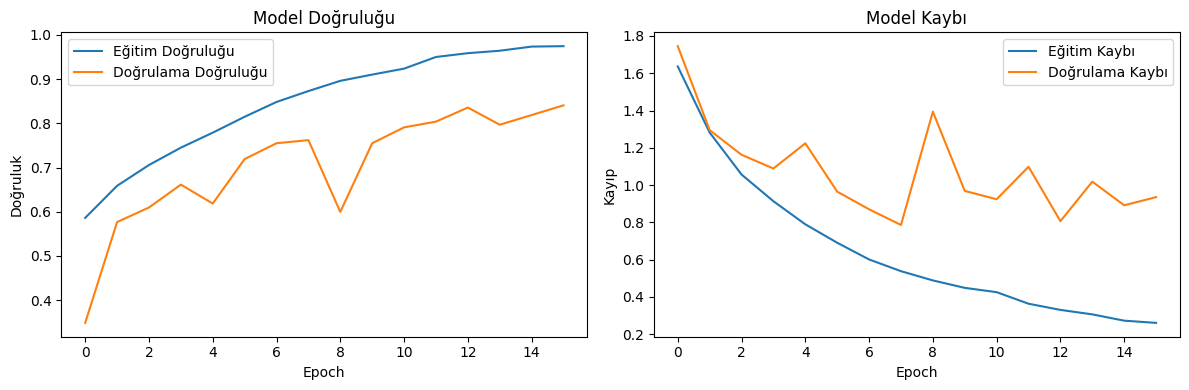

In [13]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.7874
F1 Score: 0.7873
ROC-AUC Score: 0.8544


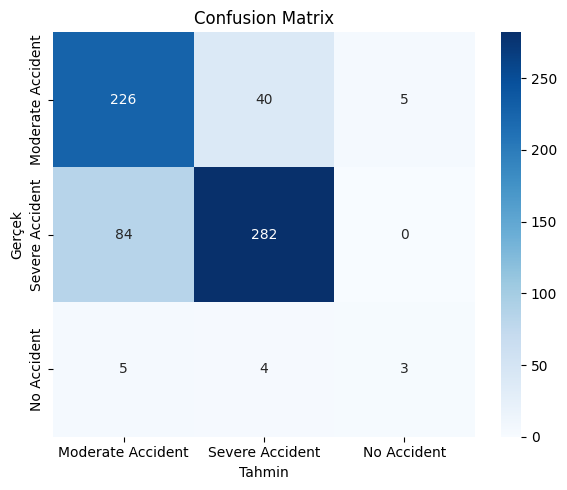


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.72      0.83      0.77       271
  Severe Accident       0.87      0.77      0.82       366
      No Accident       0.38      0.25      0.30        12

         accuracy                           0.79       649
        macro avg       0.65      0.62      0.63       649
     weighted avg       0.79      0.79      0.79       649



In [14]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, original_test_dataset, class_names)

# Augmented veri seti ile model eğitimi ve metrik sonuçları

In [19]:
tf.keras.backend.set_value(model.optimizer.learning_rate, 0.0005)#learning_rate ilk eğitimde yarıya indiğinden, burada tekrar sıfırlandı.

In [20]:
history = model.fit(
    augmented_train_dataset,
    validation_data=original_valid_dataset,
    batch_size=32,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfd in position 335: invalid start byte

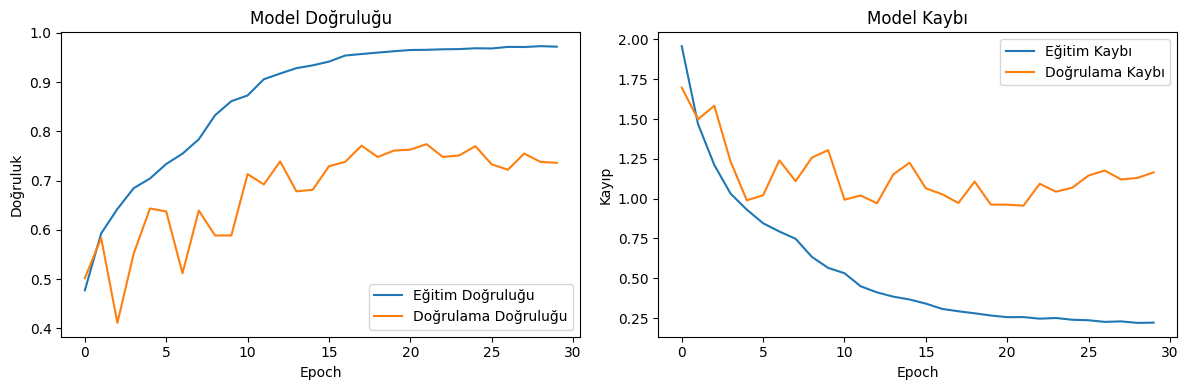

In [14]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.8860
F1 Score: 0.9053
ROC-AUC Score: 0.9468


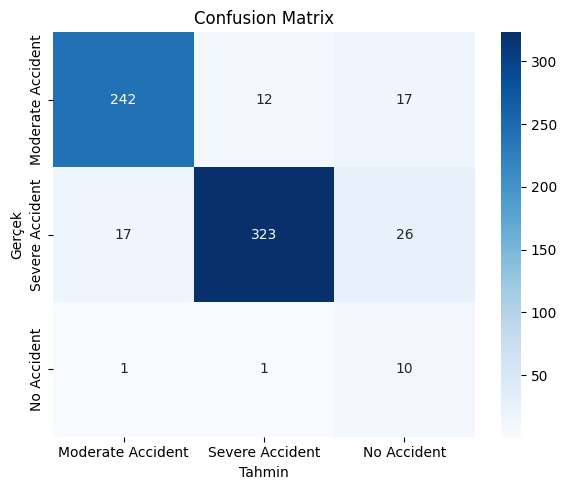


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.93      0.89      0.91       271
  Severe Accident       0.96      0.88      0.92       366
      No Accident       0.19      0.83      0.31        12

         accuracy                           0.89       649
        macro avg       0.69      0.87      0.71       649
     weighted avg       0.93      0.89      0.91       649



In [15]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, augmented_test_dataset, class_names)

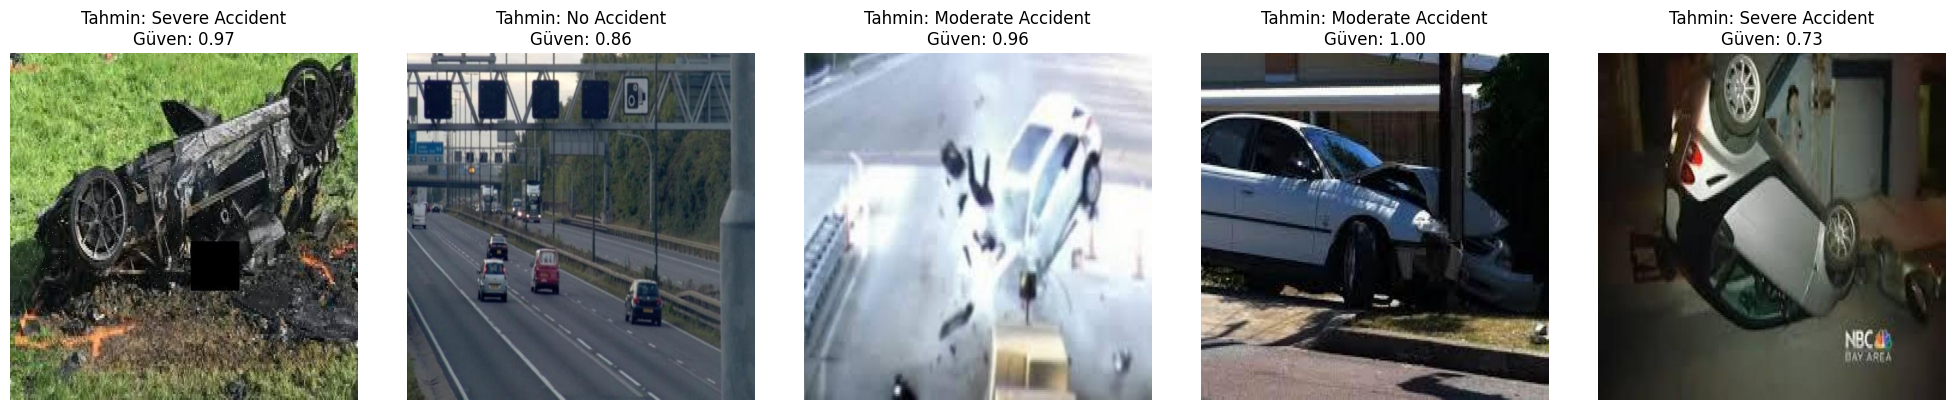

In [13]:
test_image_paths = test_df['filename'].tolist()  # Test seti görüntü yolları
# Tahminlerin görselleştirilmesi
utils.visualize_predictions(
    model=model,
    image_paths=test_image_paths,
    class_names=class_names,
    num_images=5
)